In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import omnitool
from omnitool.literature_values import *

import sys


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_data():
    sfile = '/home/oliver/PhD/Gaia_Project/data/KepxDR2/xyu18.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

In [3]:
df = read_data()

#Lets kill: Nan parallaxes, high errors and duplicates
print('Removing NaN parallaxes')
print('Before: '+str(len(df)))
df = df[np.isfinite(df.parallax)]
df = df[df.parallax_error < 0.3*df.parallax]
df.drop_duplicates('KICID',inplace=True)
df = df.reindex()
print('After: '+str(len(df)))
df.head(2)

Removing NaN parallaxes
Before: 16135
After: 15719


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,yu_logg,yu_logg_err,[Fe/H],...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,757137,29.99,0.60,3.399,0.011,4751,139,2.383,0.012,-0.08,...,-0.947,DSEP,0.0,0.0,0.0,7.467,6.853,6.722,none,0.239476
1,892010,17.85,0.89,2.427,0.078,4834,151,2.161,0.023,0.21,...,-2.266,DSEP,0.0,0.0,0.0,9.784,9.168,9.041,none,0.297685


In [4]:
'''<<<ASTEROSEISMIC>>>'''
#Now lets run scaling relations and get the bolometric magnitudes
sc = omnitool.scalings(df, df.numax, df.dnu, df. Teff,\
                      _numax_err = df.numax_err, _dnu_err = df.dnu_err,\
                      _Teff_err = df.Teff_err)
df['R'] = sc.get_radius()/Rsol
df['R_err'] = sc.get_radius_err()/Rsol
df['M'] = sc.get_mass()/Msol
df['M_err'] = sc.get_mass_err()/Msol
df['logg'] = sc.get_logg()
df['logg_err'] = sc.get_logg_err()
df['L'] = sc.get_luminosity()/Lsol
df['L_err'] = sc.get_luminosity_err()/Lsol
df['Mbol'] = sc.get_bolmag()
df['Mbol_err'] = sc.get_bolmag_err()
df['Z'] = Zsol * 10 ** df['[Fe/H]'].values

#Now lets get the bolometric correction going
get_bc = omnitool.bolometric_correction(df.Teff.values,\
                                       df.logg.values,\
                                       df.Z.values,)
df['ast_MKs'] = df.Mbol - get_bc(band='Ks')
df['ast_MH'] = df.Mbol - get_bc(band='H')
df['ast_MJ'] = df.Mbol - get_bc(band='J')
df['ast_M_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

100%|██████████| 15719/15719 [00:09<00:00, 1734.58it/s]


In [5]:
'''<<<ASTROMETRIC>>>'''
#Now lets collect the absolute magnitude from reddening
#We're going to estimate the distance uncertainties as symmetric
df['r_err'] = np.sqrt((df.r_hi-df.r_est)**2 + (df.r_est - df.r_lo)**2)

sg = omnitool.spyglass()
sg.pass_position(df.ra,df.dec,frame='icrs')
sg.pass_distance(df.r_est, df.r_err)

sg.pass_magnitude(df.kmag, band='Ks')
df['phot_MKs'], df['phot_MKs_err'] = sg.get_M()
sg.pass_magnitude(df.hmag, band='H')
df['phot_MH'], df['phot_MH_err'] = sg.get_M()
sg.pass_magnitude(df.jmag, band='J')
df['phot_MJ'], df['phot_MJ_err'] = sg.get_M()

#Now we need to check content for Nans
print('Before : '+str(len(df)))
df = df[np.isfinite(df.phot_MKs)]
df = df[np.isfinite(df.phot_MH)]
df = df[np.isfinite(df.phot_MJ)]
print('After : '+str(len(df)))

Before : 15719
After : 15718


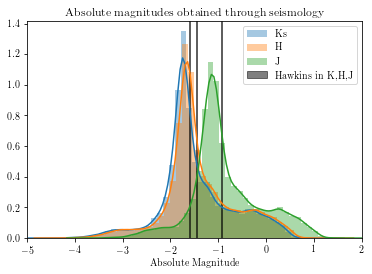

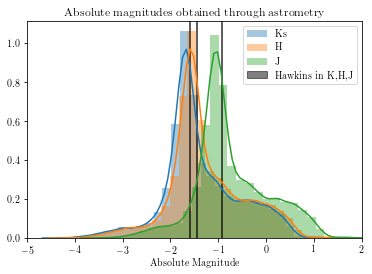

In [6]:
sns.distplot(df.ast_MKs, label='Ks')
sns.distplot(df.ast_MH,label='H')
sns.distplot(df.ast_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through seismology')
plt.xlabel('Absolute Magnitude')
plt.legend()
plt.xlim(-5, 2.)
plt.show()

sns.distplot(df.phot_MKs, label='Ks')
sns.distplot(df.phot_MH,label='H')
sns.distplot(df.phot_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through astrometry')
plt.xlabel('Absolute Magnitude')
plt.xlim(-5, 2.)
plt.legend()
plt.show()

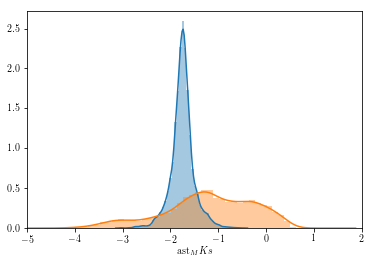

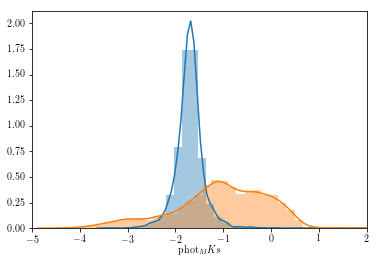

In [7]:
sel = df.stage == 2
sns.distplot(df.ast_MKs[sel], label='Ks')
sns.distplot(df.ast_MKs[~sel])
plt.xlim(-5, 2.)
plt.show()
sel = df.stage == 2
sns.distplot(df.phot_MKs[sel], label='Ks')
sns.distplot(df.phot_MKs[~sel])
plt.xlim(-5, 2.)
plt.show()

In [8]:
#Lets calculate the magnitude differences
Kdiff = df.ast_MKs - df.phot_MKs
Kdiff_err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)

Hdiff = df.ast_MH - df.phot_MH
Hdiff_err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)

Jdiff = df.ast_MJ - df.phot_MJ
Jdiff_err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)

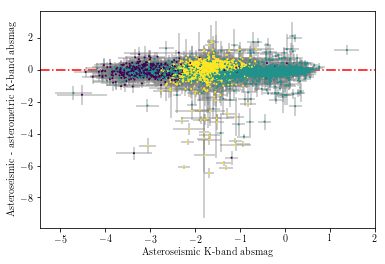

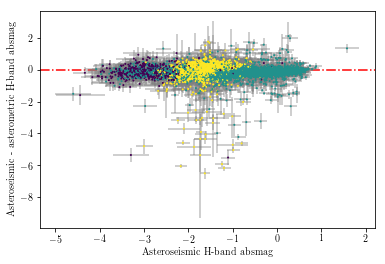

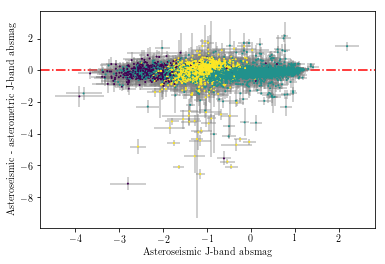

In [9]:
#Plot differences between the two magnitudes
fig, ax = plt.subplots()
diff = df.ast_MKs - df.phot_MKs
err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MKs,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MKs,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic K-band absmag')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MH - df.phot_MH
err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MH,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MH,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic H-band absmag')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MJ - df.phot_MJ
err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MJ,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MJ,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic J-band absmag')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

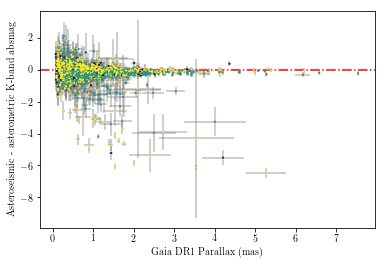

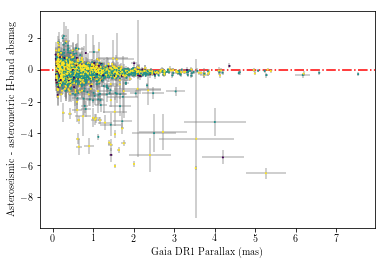

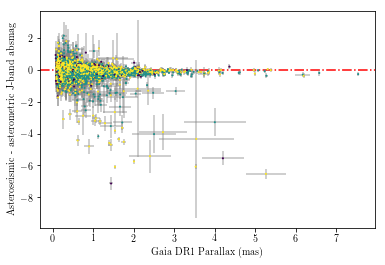

In [10]:
#Now lets plot the difference against distance
fig, ax = plt.subplots()
ax.scatter(df.parallax,Kdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Kdiff,xerr=df.parallax_error,yerr=Kdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.parallax,Hdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Hdiff,xerr=df.parallax_error,yerr=Hdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.parallax,Jdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.parallax,Jdiff,xerr=df.parallax_error,yerr=Jdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

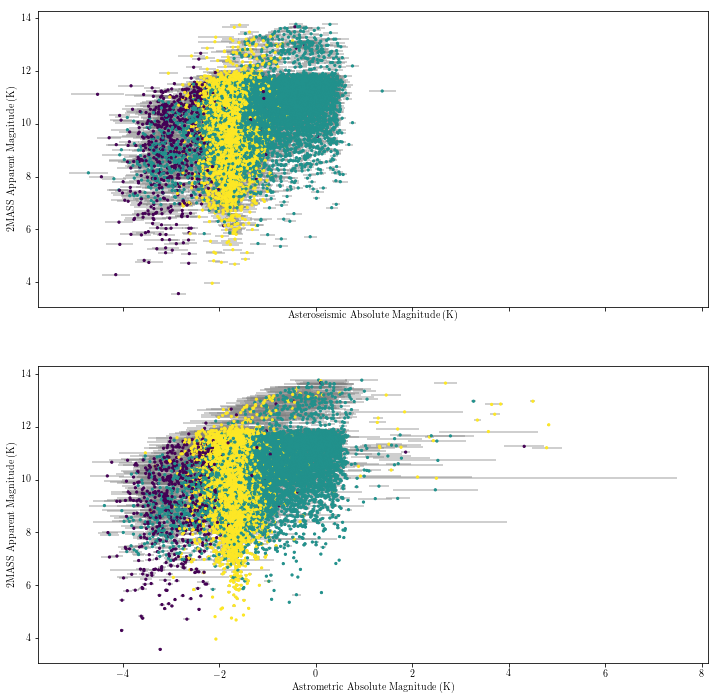

In [11]:
#Lets plot the absolute vs apparent magnitude for both types for the K band
fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize=(12,12))
ax1.scatter(df.ast_MKs,df.kmag,s=5,c=df.stage,zorder=1000)
ax1.errorbar(df.ast_MKs,df.kmag,xerr=df.ast_M_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax1.set_xlabel('Asteroseismic Absolute Magnitude (K)')
ax1.set_ylabel('2MASS Apparent Magnitude (K)')

# fig, ax = plt.subplots()
ax2.scatter(df.phot_MKs,df.kmag,s=5,c=df.stage,zorder=1000)
ax2.errorbar(df.phot_MKs,df.kmag,xerr=df.phot_MKs_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax2.set_xlabel('Astrometric Absolute Magnitude (K)')
ax2.set_ylabel('2MASS Apparent Magnitude (K)')
plt.show()